In [1]:
"""
- Why am I doing s_norm[:, :, 1] *= -1 in process panel
    - ? Shouldn't be there
    - s_norm is only used to calculate absorption and the multiplication only really affects the angle
    
- Can I identify panels where I don't need to include in the optimization

file:
/net/dials/raid1/sauter/bernina/spectrum_masters/run_000795.JF07T32V01_master.h5

Vanessa converted the first frame to a cbf and put it at
/net/cci/voklejas/repos/dials/build/dials_data/converted.cbf

Possible utilities
    /home/david/dials_dev/modules/dials/util/image_viewer/slip_viewer/tile_generation.py
"""

"\n- Why am I doing s_norm[:, :, 1] *= -1 in process panel\n- Can I identify panels where I don't need to include in the optimization\n\nfile:\n/net/dials/raid1/sauter/bernina/spectrum_masters/run_000795.JF07T32V01_master.h5\n\nVanessa converted the first frame to a cbf and put it at\n/net/cci/voklejas/repos/dials/build/dials_data/converted.cbf\n\nPossible utilities\n    /home/david/dials_dev/modules/dials/util/image_viewer/slip_viewer/tile_generation.py\n"

In [2]:
import sys
sys.path.append('/home/david/dials_dev/modules/dxtbx/src')
sys.path.append('/home/david/dials_dev/build/lib')
sys.path.append('/home/david/dials_dev/modules')
from cctbx import factor_kev_angstrom
from dials.array_family import flex
import dxtbx
#from dxtbx.model.experiment_list import ExperimentListFactory
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

import Modules_Multipanel as MOD


mpl.rc_file('matplotlibrc.txt')

In [5]:
image_file_name = '/home/david/Documents/Background/Data/converted.cbf'
image = dxtbx.load(image_file_name)
beam = image.get_beam()
wavelength = beam.get_wavelength()
data = image.get_raw_data()
detector = image.get_detector()
pixel_size = detector[0].get_pixel_size()[0]
kapton_absorption_length = MOD.get_absorption_correction()(wavelength)

In [37]:
angle = 265 * np.pi/180
h = 0.04
f = 0.665
t = 0.025
f_range = 0.1

In [126]:
def ProcessPanel(data, panel):
    I = data.as_numpy_array()
    panel_shape = panel.get_image_size()
    x, y = np.meshgrid(
        np.linspace(0, panel_shape[0] - 1, panel_shape[0]),
        np.linspace(0, panel_shape[1] - 1, panel_shape[1])
        )
    mm = panel.pixel_to_millimeter(flex.vec2_double(
        flex.double(x.flatten()),
        flex.double(y.flatten())
        ))
    s = panel.get_lab_coord(mm).as_numpy_array()
    s_norm = (s.T / np.linalg.norm(s, axis=1)).T.reshape((panel_shape[0], panel_shape[1], 3))
    s_norm[:, :, 2] *= -1
    s = s.reshape((panel_shape[0], panel_shape[1], 3))
    pad = 2
    mask = np.zeros(panel_shape, dtype=np.bool)
    mask[:pad, :] = True
    mask[-pad:, :] = True
    mask[:, :pad] = True
    mask[:, -pad:] = True
    mask = np.logical_or(
        mask,
        I <= 0
        )
    mask = np.logical_or(
        mask,
        I >= 800
        )
    I_mean = I[mask].mean() * np.ones(mask.shape)
    I_std = I[mask].std() * np.ones(mask.shape)
    if I[mask].mean() / I[mask].std() < 0.1:
        mask = np.ones(mask.shape, dtype=np.bool)
        #print('here')
    elif I[mask].mean() / I[mask].std() > 5:
        mask = np.ones(mask.shape, dtype=np.bool)
    return I, s, s_norm, I_mean, I_std, mask


def GetImage(data, detector, polarization_fraction):
    pixel_size = detector[0].get_pixel_size()[0]
    min_pos = np.zeros(2)
    max_pos = np.zeros(2, dtype=np.int)
    for index in range(16*16):
        origin = detector[index].get_origin()
        if origin[0] < min_pos[0]:
            min_pos[0] = origin[0]
        if origin[1] < min_pos[1]:
            min_pos[1] = origin[1]
    for index in range(16*16):
        origin = np.round(
            (detector[index].get_origin()[:2] - min_pos) / pixel_size,
            decimals=0
            ).astype(np.int)
        if origin[0] > max_pos[0]:
            max_pos[0] = origin[0]
        if origin[1] > max_pos[1]:
            max_pos[1] = origin[1]
    max_pos += 254
    I = -1*np.ones(max_pos[::-1])
    I_mean = -1*np.ones(max_pos[::-1])
    I_std = -1*np.ones(max_pos[::-1])
    s = -1*np.ones((*max_pos[::-1], 3))
    s_norm = -1*np.ones((*max_pos[::-1], 3))
    mask = np.zeros(max_pos[::-1], dtype=np.bool)
    for index in range(16*16):
        origin = np.round(
            (detector[index].get_origin()[:2] - min_pos) / pixel_size,
            decimals=0
            ).astype(np.int)
        I_panel, s_panel, s_norm_panel, I_mean_panel, I_std_panel, mask_panel = ProcessPanel(data[index], detector[index])
        I[origin[1]: origin[1] + 254, origin[0]: origin[0] + 254] = I_panel
        I_mean[origin[1]: origin[1] + 254, origin[0]: origin[0] + 254] = I_mean_panel
        I_std[origin[1]: origin[1] + 254, origin[0]: origin[0] + 254] = I_std_panel
        s[origin[1]: origin[1] + 254, origin[0]: origin[0] + 254] = s_panel
        s_norm[origin[1]: origin[1] + 254, origin[0]: origin[0] + 254] = s_norm_panel
        mask[origin[1]: origin[1] + 254, origin[0]: origin[0] + 254] = mask_panel
    mask = np.logical_or(
        mask,
        I <= 0
        )
    R = np.sqrt(s[:, :, 0]**2 + s[:, :, 1]**2)
    theta2 = np.arctan(R / np.abs(s[:, :, 2]))
    phi = np.pi + np.arctan2(s[:, :, 1], s[:, :, 0])
    polarization = (1 - polarization_fraction*np.cos(2*phi)*np.sin(theta2)**2 / (1+np.cos(theta2)**2))
    theta2_int = np.linspace(0, 60, 121) * np.pi/180
    integratation_indices = np.invert(mask)

    integration_sum = np.histogram(
        theta2[integratation_indices].flatten(),
        bins=theta2_int,
        weights=I[integratation_indices].flatten()
        )
    integration_counts = np.histogram(
        theta2[integratation_indices].flatten(),
        bins=theta2_int
        )
    bins = integration_counts[1]
    bin_centers = (bins[1:] + bins[:-1])/2
    integrated = integration_sum[0] / integration_counts[0]
    indices = np.invert(np.isnan(integrated))
    integrated_image = np.interp(theta2, bin_centers[indices], integrated[indices])
    integrated_image[mask] = -1
    return I, s, s_norm, mask, theta2, phi, polarization, integrated_image, I_mean, I_std

In [127]:
polarization_fraction = 0.9
I, s, s_norm, mask, theta2, phi, polarization, integrated_image, I_mean, I_std =\
   GetImage(data, detector, polarization_fraction)
absorption = MOD.IntegrateModel(angle, h, f, t, s_norm, kapton_absorption_length, f_range, n=3)


/tmp/ipykernel_12737/1899269787.py:33: RuntimeWarning: invalid value encountered in double_scalars
  if I[mask].mean() / I[mask].std() < 0.1:
/tmp/ipykernel_12737/1899269787.py:36: RuntimeWarning: invalid value encountered in double_scalars
  elif I[mask].mean() / I[mask].std() > 5:


here too
7.2375436299881795

here too
5.654453617997876



/tmp/ipykernel_12737/1899269787.py:104: RuntimeWarning: invalid value encountered in true_divide
  integrated = integration_sum[0] / integration_counts[0]


In [132]:
s[:, :, 0].max()

158.11640400659772

0.3715843867459338


0.6849092628286723


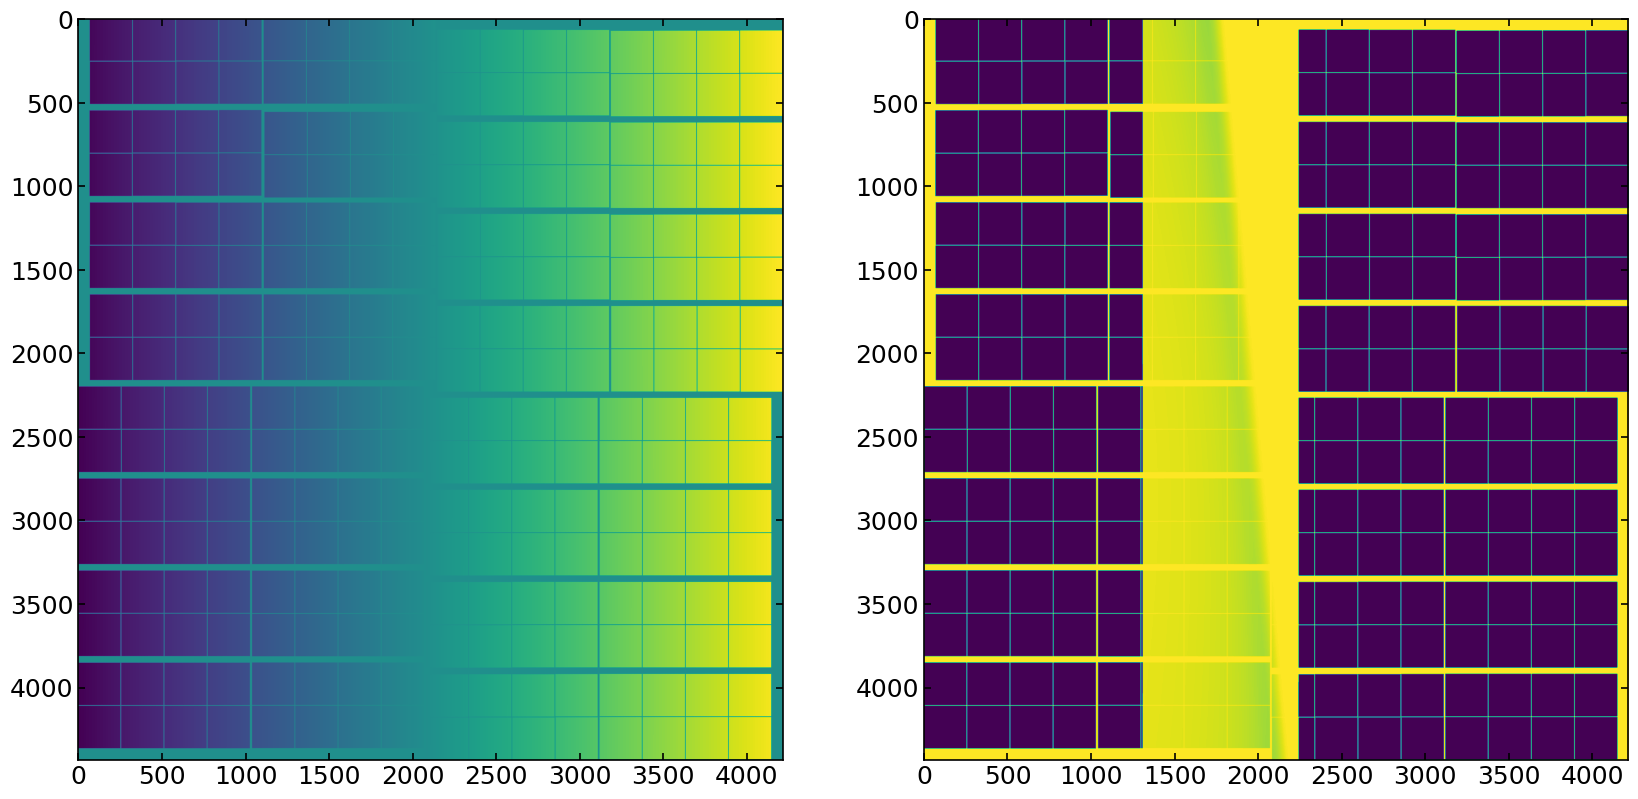

In [146]:
indices = np.logical_or(
    s[:, :, 0] > 10,
    s[:, :, 0] < -60
    )
absorption_new = absorption.copy()
absorption_new[indices] = 0
print(indices.sum() / indices.size)
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(s[:, :, 0])
axes[1].imshow(absorption_new)
plt.show()

/tmp/ipykernel_12737/1271829616.py:10: RuntimeWarning: invalid value encountered in true_divide
  axes[0].imshow(I_std / I_mean, vmin=0, vmax=0.1)
/tmp/ipykernel_12737/1271829616.py:11: RuntimeWarning: invalid value encountered in true_divide
  axes[1].imshow(I_std / I_mean, vmin=7, vmax=10)


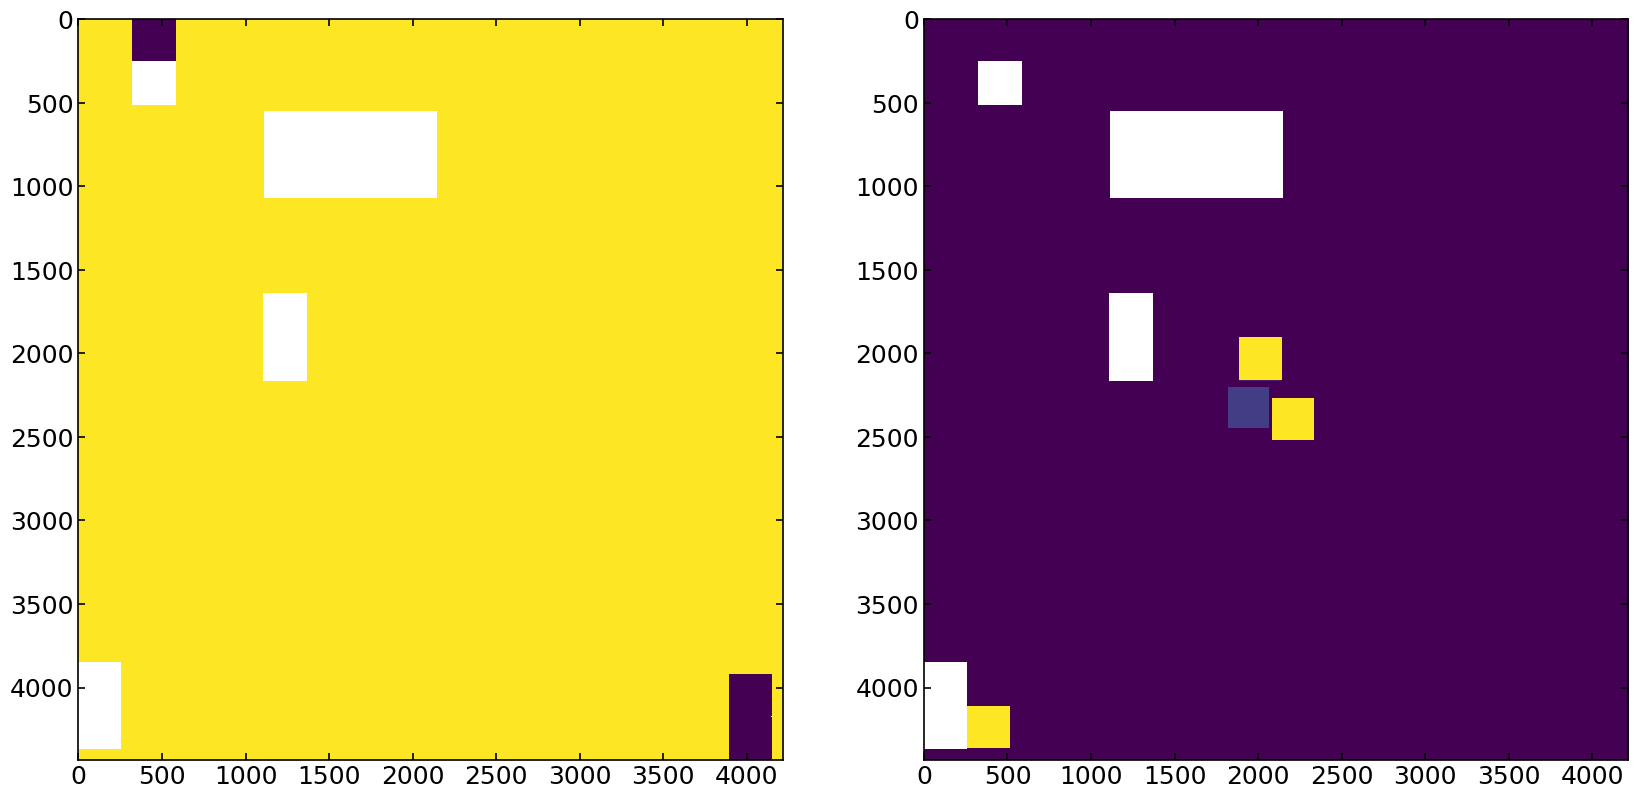

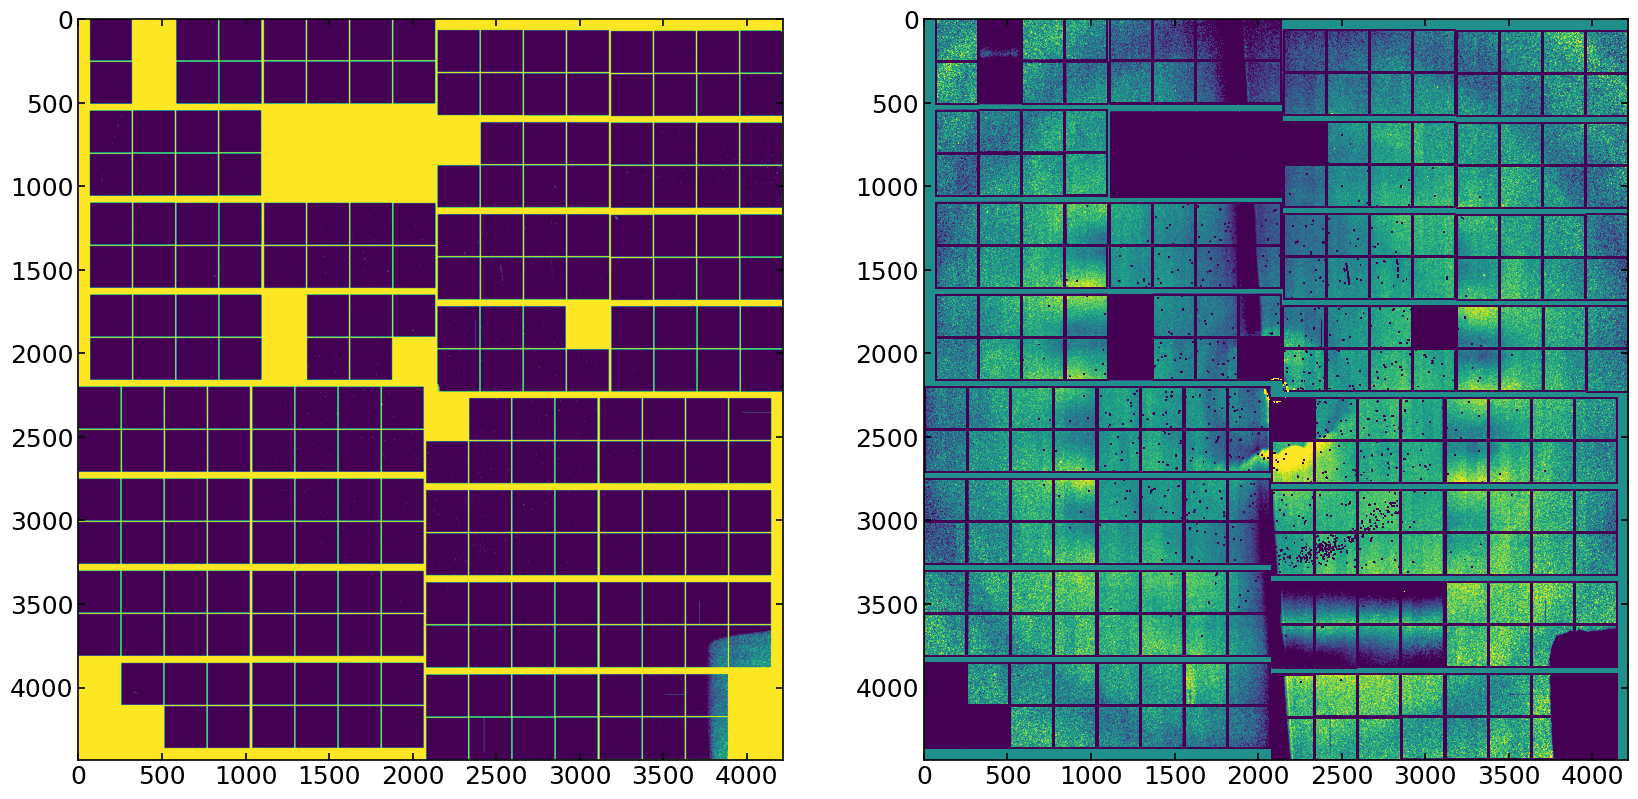

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

"""indices = np.logical_and(
    I_std <= 0,
    I_mean <= 0
    )
I_mean[indices] = 0
I_std[indices] = 0
"""
axes[0].imshow(I_std / I_mean, vmin=0, vmax=0.1)
axes[1].imshow(I_std / I_mean, vmin=7, vmax=10)

fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(mask)
axes[1].imshow(I / (polarization * integrated_image), vmin=0.8, vmax=1.2)
plt.show()